In [97]:
# general imports
import contextlib
import signal
import sys
import json
import torch
import csv
from time import sleep
# carla gym wrapper
import gym
from pathlib import Path
# plots
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import csv
import os
import matplotlib
from matplotlib import rc
from scipy.interpolate import make_interp_spline, BSpline

In [98]:
# info - map
info_map = {'reward': 'r_mean', 'wpp': 'waypoints_percent', 'collision': 'collision'}

rc('font',**{'family':'serif','serif':['Palatino'], 'size': 9})
rc('text', usetex=True)
from matplotlib.font_manager import FontProperties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from colormap import hex2rgb
muted_colours_list = ["#4878D0", "#D65F5F", "#EE854A", "#6ACC64", "#956CB4",
                      "#8C613C", "#DC7EC0", "#505050", "#D5BB67", "#82C6E2"]
muted_colours_list = np.asarray([hex2rgb(_c) for _c in muted_colours_list]) / 256
muted_colours_dict = {'blue':   muted_colours_list[0],
                      'red':    muted_colours_list[1],
                      'orange': muted_colours_list[2],
                      'green':  muted_colours_list[3],
                      'purple': muted_colours_list[4],
                      'brown':  muted_colours_list[5],
                      'pink':   muted_colours_list[6],
                      'gray':   muted_colours_list[7],
                      'yellow': muted_colours_list[8],
                      'eggsh':  muted_colours_list[9]}

fill_alpha = 0.5
main_line_width = 1.5
edge_alpha = 0.8
paper_width = 5.5  # INCHES.
fig_size = (paper_width / 2.0,
            paper_width / 2.5)

label_map = {'ad-agent': 'AIL (POMDP)',
              'rl-agent': 'RL (POMDP)',
              'ad-expert': 'AIL (MDP)',
              'rl-expert': 'RL (MDP)',
              'a2d-agent': 'A2D'}

var_map = {'wpp': 'Waypoint Percentage',
           'time_steps': 'Environment Interactions',
           'reward': 'Cumulative Reward',
           'collision': 'Collision End Percentage'}

minmax_map = {'wpp': [5,109],  'time_steps': [0,4e5],
              'reward': [15,75], 'collision': [-5,60]}


cols_dict = {'ad-agent':          muted_colours_dict['blue'],# np.asarray([0.8, 0.8, 0.8, 1.0]),
             'ad-expert':   muted_colours_dict['orange'],
             'rl-agent':         muted_colours_dict['red'],
             'rl-expert':   muted_colours_dict['yellow'],
             'a2d-agent':         muted_colours_dict['green'],
             # 'adbv':  muted_colours_dict['eggsh'],
             # 'a2dcp':        muted_colours_dict['green'],
             # 'ete_observe':        muted_colours_dict['brown'],
             # 'D_state':            muted_colours_dict['eggsh'],
             # 'A2D_state':          muted_colours_dict['eggsh'],
             # 'a2dbv':    muted_colours_dict['eggsh'],
             # 'A2D_observe_ppo':   muted_colours_dict['purple'],
             # 'rlfv_ppo':    muted_colours_dict['pink']
             }

In [99]:
def load_algo_data(base_file='scenario_1',file='a2d-agent',info='reward'):
    
    # define info-dict
    plot_dict = {}
    
    # load data
    df = pd.read_csv(base_file+'/'+file+'/'+info+'.csv')

    # drop rows with na
    df = df.dropna()
    
    # remove bullshit-columns
    time_steps = df['time_steps']
    df = df[[c for c in df.columns if ((info_map[info] in c) and ('MIN' not in c) and ('MAX' not in c))]]
    df.apply(pd.to_numeric, errors='ignore')
    
    # compute percentiles
    quant_75= df.quantile(q=0.75, axis=1, numeric_only=True, interpolation='linear')
    quant_25 = df.quantile(q=0.25, axis=1, numeric_only=True, interpolation='linear')
    mean = df.mean(axis=1)
    median = df.median(axis=1)
    
    #
    df['quant_75']=quant_75
    df['quant_25']=quant_25
    df['mean']=mean
    df['median']=median
    
    # add back in time_steps
    df['time_steps'] = time_steps
    
    # 
    return df

In [100]:
def load_data(scenario='scenario_1', attrib='rewards'):
    plot_data = {}
    plot_data['ad-agent'] = load_algo_data(base_file=scenario,file='ad-agent',info=attrib)
    plot_data['ad-expert'] = load_algo_data(base_file=scenario,file='ad-expert',info=attrib)
    plot_data['rl-agent'] = load_algo_data(base_file=scenario,file='rl-agent',info=attrib)
    plot_data['rl-expert'] = load_algo_data(base_file=scenario,file='rl-expert',info=attrib)
    plot_data['a2d-agent'] = load_algo_data(base_file=scenario,file='a2d-agent',info=attrib)
    return plot_data

In [101]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [102]:
def _plot(plot_data, ax, xaxis='time_steps', yaxis='collision', stats=['quant_25','quant_75'],
            smooth_data=False, smooth_coeff=5):

    # plot it all
    labels = plot_data.keys()

    max_ts = 0
    for _k in labels:
        max_ts = max(plot_data[_k]['time_steps'].values.flatten()[-1],max_ts)

    for _k in list(labels):
        
        # get statistics
        _mean = plot_data[_k]['mean'].values.flatten() #smooth(, 5)
        _uqu = plot_data[_k][stats[0]].values.flatten() #smooth(, 5)
        _lqu = plot_data[_k][stats[1]].values.flatten() #smooth(, 5)
        
        # make sure smoothing didnt guff anything
        _mean = np.array([max(_mean[i],_uqu[i]) for i in range(len(_mean))])
        _mean = np.array([min(_mean[i],_lqu[i]) for i in range(len(_mean))])
        
        # set x axis
        _x = plot_data[_k]['time_steps'].values.flatten()
        
        # append final values to each
        _x = np.append(_x, [max_ts + i for i in range(25)])
        _mean = np.append(_mean, [_mean[-1] for _ in range(25)])
        _uqu = np.append(_uqu, [_uqu[-1] for _ in range(25)])
        _lqu = np.append(_lqu, [_lqu[-1] for _ in range(25)])
        
        # smooth
        if smooth_data:
            _mean = smooth(_mean,smooth_coeff)[:-24] #smooth(, 5)
            _uqu = smooth(_uqu,smooth_coeff)[:-24] #smooth(, 5)
            _lqu = smooth(_lqu,smooth_coeff)[:-24] #smooth(, 5)
            _x = _x[:-24]
        
        # 
        if yaxis in ['wpp','collision']:
            _mean *= 100
            _uqu *= 100
            _lqu *= 100
        if yaxis in ['wpp']:
            _mean *= 11/10
            _uqu *= 11/10
            _lqu *= 11/10
        
        # add dotted line for clarity
        _h_mean = [_mean[-1] for _ in range(len(_lqu))]
        
        # If you have multiple experiments.
        if _k == 'a2d-agent':
            ax.plot(_x, _mean, color=cols_dict[_k], label=label_map[_k], linewidth=main_line_width, zorder=99999,alpha=0.8)
            ax.fill_between(_x, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)
            ax.plot(_x, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
            ax.plot(_x, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        elif 'ad' in _k:
            ax.plot(_x, _mean, color=cols_dict[_k], label=label_map[_k], linewidth=main_line_width, linestyle=':',alpha=0.8)
            ax.fill_between(_x, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)
            ax.plot(_x, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
            ax.plot(_x, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        else:
            ax.plot(_x, _mean, color=cols_dict[_k], label=label_map[_k], linewidth=main_line_width,alpha=0.8)
            ax.fill_between(_x, _uqu, _lqu, alpha=fill_alpha, color=cols_dict[_k], linewidth=0)
            ax.plot(_x, _lqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
            ax.plot(_x, _uqu, color=cols_dict[_k], linewidth=0.2, alpha=edge_alpha)
        ax.yaxis.tick_right()
    
    # plt.show()
    ax.grid(True)
    ax.set_xlabel(var_map[xaxis])
    ax.set_ylabel(var_map[yaxis])
    
    # now add expert lines
    if yaxis == 'reward':
        ax.hlines(70,xmin=minmax_map['time_steps'][0], label='MDP',\
                     xmax=minmax_map['time_steps'][1], color='black', 
                     linestyles='dashed',linewidth=1)
        ax.hlines(65,xmin=minmax_map['time_steps'][0], label='POMDP',\
                     xmax=minmax_map['time_steps'][1], color='black', 
                     linestyles='dotted',linewidth=2)
    elif yaxis == 'wpp':
        ax.hlines(100,xmin=minmax_map['time_steps'][0], label='MDP', \
                      xmax=minmax_map['time_steps'][1], color='black', 
                     linestyles='dashed',linewidth=1)
        ax.hlines(100,xmin=minmax_map['time_steps'][0], label='POMDP', \
                      xmax=minmax_map['time_steps'][1], color='black', 
                     linestyles='dotted',linewidth=2)
    elif yaxis == 'collision':
        ax.hlines(0.,xmin=minmax_map['time_steps'][0], label='MDP',\
                      xmax=minmax_map['time_steps'][1], color='black', 
                      linestyles='dashed',linewidth=1)
        ax.hlines(0.,xmin=minmax_map['time_steps'][0], label='POMDP',\
                      xmax=minmax_map['time_steps'][1], color='black', 
                      linestyles='dotted',linewidth=2)
    else:
        raise Exception()
    
    return ax

In [103]:
def generate_plots(base_dir = './Desktop/final_results',
        xaxis = 'time_steps', yaxis='wpp', max_interactions = 400000,
        exp_root = 'scenario_1', include_legend = False, smooth_data=False, smooth_coeff=5):

    # load in data sources
    data_dict = load_data(scenario='scenario_1', attrib=yaxis)
    fig = plt.figure()
    ax = plt.gca()
    
    # ax.ticklabel_format(axis='x', style='sci')
    fig.set_size_inches(fig_size)
    plt.tight_layout()
    
    # Do plot
    ax = _plot(data_dict, ax, yaxis=yaxis,smooth_data=smooth_data, smooth_coeff=smooth_coeff)
    
    # Place legend.
    ax = plt.gca()
    fontP = FontProperties()
    fontP.set_size('medium')
    ax.margins(0.02, 0.2, tight=None)

    ax.grid(True)
    if yaxis in ['wpp','collision']:
        ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.set_xlabel(var_map[xaxis])
    ax.set_ylabel(var_map[yaxis])
    plt.xlim(0, max_interactions)
    plt.ylim(minmax_map[yaxis][0], minmax_map[yaxis][1])
    ax.ticklabel_format(axis='x', style='sci',scilimits=(0,0))
    if include_legend:
        plt.legend(loc='best', prop={'size': 6}, ncol=2)

    save_name = xaxis+'_'+yaxis+'_results.pdf'
    plt.savefig('/Users/wilder/Desktop/icml_2021/' + save_name, bbox_inches = 'tight', pad_inches=0.01)
    plt.savefig('/Users/wilder/Desktop/icml_2021/' + 'legend_' + save_name, bbox_inches = 'tight', pad_inches=0.01)
    plt.savefig(exp_root +'_'+ save_name, bbox_inches = 'tight', pad_inches=0.05)
    plt.show()

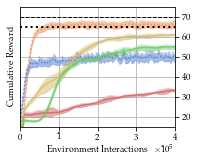

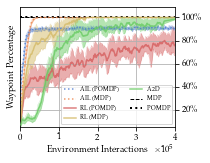

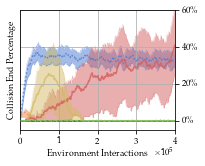

In [104]:
generate_plots(base_dir='Desktop/icml_2021', xaxis='time_steps', yaxis='reward', smooth_data=True, smooth_coeff=10)
generate_plots(base_dir='Desktop/icml_2021', xaxis='time_steps', yaxis='wpp', include_legend=True, smooth_data=True, smooth_coeff=5)
generate_plots(base_dir='Desktop/icml_2021', xaxis='time_steps', yaxis='collision', smooth_data=True, smooth_coeff=15)

In [9]:
summary_df

,expert_eval_invasion_end_med,expert_eval_episode_waypoints_hit_max,expert_eval_reward_contributions_action_penalty_max,_runtime,episode_waypoints_percent_max,episode_waypoints_percent_min,expert_eval_episode_waypoints_percent_max,expert_eval_episode_waypoints_percent_min,reward_contributions_completed_bonus_mean,expert_eval_reward_contributions_completed_bonus_mean,...,expert_episode_waypoints_percent_med,expert_reward_contributions_action_penalty_min,expert_invasion_end_med,expert_reward_contributions_pid_bonus_mean,expert_time_out_end_mean,expert_reward_contributions_action_penalty_mean,expert_masked_r_mean_min,expert_scenario_solved_med,expert_episode_waypoints_hit_mean,expert_reward_contributions_action_penalty_max
0,0.0,57.0,-0.003315,30713.593727,0.919355,0.112903,0.919355,0.758065,0.0000,0.006667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,42918.844451,0.909091,0.636364,NaN,NaN,0.0704,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,43858.623211,0.909091,0.636364,NaN,NaN,0.0812,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,43037.903187,0.909091,0.636364,NaN,NaN,0.0744,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,43366.952103,0.909091,0.636364,NaN,NaN,0.0808,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,NaN,NaN,NaN,28799.950046,0.909091,0.090909,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,NaN,NaN,NaN,951.205057,0.909091,0.909091,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,NaN,NaN,NaN,737.060044,0.909091,0.090909,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,NaN,NaN,NaN,843.970674,0.909091,0.909091,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
load_algo_data(base_file='scenario_1',file='a2d-agent',info='wpp')

     time_steps  fancy-sweep-9 - _step  fancy-sweep-9 - _step__MIN  \
0             0                    0.0                         0.0   
1          1700                    1.0                         1.0   
2          3400                    2.0                         2.0   
3          5100                    3.0                         3.0   
4          6800                    4.0                         4.0   
..          ...                    ...                         ...   
230      391000                    NaN                         NaN   
231      392700                    NaN                         NaN   
232      394400                    NaN                         NaN   
233      396100                    NaN                         NaN   
234      397800                    NaN                         NaN   

     fancy-sweep-9 - _step__MAX  \
0                           0.0   
1                           1.0   
2                           2.0   
3                  

[235 rows x 61 columns]
     fancy-sweep-9 - agent_eval_episode_waypoints_percent_mean  \
1                                             0.121212           
2                                             0.060606           
3                                             0.030303           
4                                             0.090909           
5                                             0.121212           
..                                                 ...           
215                                           0.787879           
216                                           0.909091           
217                                           0.909091           
218                                           0.818182           
219                                           0.909091           

     fragrant-sweep-8 - agent_eval_episode_waypoints_percent_mean  \
1                                             0.151515              
2                                            

[219 rows x 15 columns]


,fancy-sweep-9 - agent_eval_episode_waypoints_percent_mean,fragrant-sweep-8 - agent_eval_episode_waypoints_percent_mean,deft-sweep-7 - agent_eval_episode_waypoints_percent_mean,treasured-sweep-6 - agent_eval_episode_waypoints_percent_mean,pleasant-sweep-5 - agent_eval_episode_waypoints_percent_mean,scarlet-sweep-4 - agent_eval_episode_waypoints_percent_mean,serene-sweep-2 - agent_eval_episode_waypoints_percent_mean,zesty-sweep-3 - agent_eval_episode_waypoints_percent_mean,gentle-sweep-1 - agent_eval_episode_waypoints_percent_mean,helpful-sweep-3 - agent_eval_episode_waypoints_percent_mean,quant_75,quant_25,mean,median,time_steps
1,0.121212,0.151515,0.151515,0.030303,0.121212,0.030303,0.000000,0.151515,0.090909,0.121212,0.143939,0.045455,0.096970,0.121212,1700
2,0.060606,0.090909,0.121212,0.181818,0.121212,0.090909,0.121212,0.151515,0.151515,0.151515,0.151515,0.098485,0.124242,0.121212,3400
3,0.030303,0.121212,0.090909,0.090909,0.151515,0.060606,0.060606,0.121212,0.090909,0.090909,0.113636,0.068182,0.090909,0.090909,5100
4,0.090909,0.090909,0.121212,0.121212,0.181818,0.060606,0.181818,0.121212,0.090909,0.151515,0.143939,0.090909,0.121212,0.121212,6800
5,0.121212,0.090909,0.151515,0.060606,0.060606,0.060606,0.151515,0.121212,0.090909,0.121212,0.121212,0.068182,0.103030,0.106061,8500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,0.787879,0.787879,0.909091,0.909091,0.909091,0.909091,0.848485,0.878788,0.909091,0.757576,0.909091,0.803030,0.860606,0.893939,365500
216,0.909091,0.818182,0.909091,0.909091,0.818182,0.696970,0.787879,0.696970,0.878788,0.878788,0.901515,0.795455,0.830303,0.848485,367200
217,0.909091,0.757576,0.666667,0.727273,0.909091,0.909091,0.909091,0.757576,0.909091,0.878788,0.909091,0.757576,0.833333,0.893939,368900
218,0.818182,0.909091,0.848485,0.818182,0.848485,0.666667,0.909091,0.909091,0.909091,0.787879,0.909091,0.818182,0.842424,0.848485,370600


In [127]:
from PIL import Image
import torchvision.transforms.functional as TF

image = Image.open('1_front_view_28.png')
x = TF.to_tensor(image)[0,...]
plt.imshow(x.numpy(), cmap='gray')
plt.show()

torch.Size([88, 200])


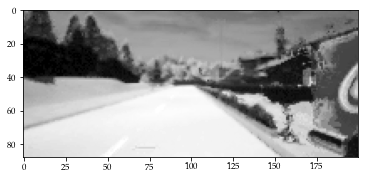

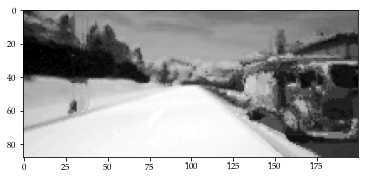

In [132]:
image = Image.open('1_front_view_21.png')
x = TF.to_tensor(image)[0,...]
plt.imshow(x.numpy(), cmap='gray')
plt.show()

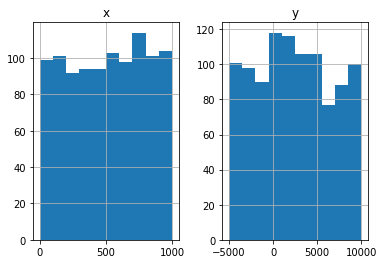

In [63]:
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

min_x, max_x = 1, 1000
min_y, max_y = -5000, 10000

xedges = numpy.linspace(min_x, max_x, num=50)
yedges = numpy.linspace(min_y, max_y, num=50)

df = pd.DataFrame({
    'x': np.random.uniform(min_x, max_x, 1000),
    'y': np.random.uniform(min_y, max_y, 1000)})

fig = df.hist()
plt.savefig('figure.pdf') 

In [67]:
x = [[(x,y) for x in range(10)] for y in range(5)]

In [69]:
import torch

In [71]:
torch.tensor(x).size()

torch.Size([5, 10, 2])

In [73]:
x = [(11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (10, 15.915317371190268, -16.556314265542955, 18), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (10, 15.915317371190268, -16.556314265542955, 18), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (14, 15.506404218098767, -14.594655759519508, 16), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (0, 14.305064203390387, -17.537143518554686, 19), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23), (11, 21.10513517743097, -21.46046053060158, 23)]

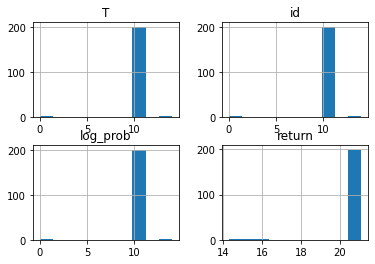